<a href="https://colab.research.google.com/github/shpotes/traffic-counter/blob/loss/notebooks/loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---


#◢ Verify Correct Runtime Settings

**<font color='#FF000'> IMPORTANT </font>**

In the "Runtime" menu for the notebook window, select "Change runtime type." Ensure that the following are selected:
* Runtime Type = Python 3
* Hardware Accelerator = GPU 


#◢ Git clone and install Faster R-CNN

In [1]:
!git clone https://github.com/shpotes/traffic-counter
%cd traffic-counter/notebooks

fatal: destination path 'traffic-counter' already exists and is not an empty directory.
/content/traffic-counter/notebooks


#◢ Setup

In [2]:
!pip install -r ../requirements.txt

In [1]:
import sys
import os
import json
from itertools import groupby
from operator import itemgetter
from typing import List, Tuple, Dict

import gin
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

sys.path.append('..')

from vehicle_nowcasting.data.data_loader import build_source_from_metadata, make_dataset, generate_anchors
from vehicle_nowcasting.data.generate_anchors import generate_anchors as gen_anch
from vehicle_nowcasting.utils import iou, plot_bb, change_box_order

%matplotlib inline

##◢ Load metadata

In [2]:
main_dir = '..'
data_dir = os.path.join(main_dir, 'data')
metadata = pd.read_csv('../data/metadata.csv')
label_map = json.load(open('../data/label_map.json', 'r'))

In [3]:
sources = build_source_from_metadata(metadata,
                                     label_map,
                                     data_dir)

In [4]:
sources[:2]

[('../data/train/15-02-15-20:17.jpg',
  [(1, 225, 117, 411, 281),
   (3, 335, 212, 456, 329),
   (3, 555, 140, 607, 210),
   (4, 470, 211, 553, 307),
   (4, 442, 138, 519, 202),
   (4, 24, 238, 147, 334),
   (4, 166, 176, 244, 258),
   (4, 388, 110, 435, 167),
   (4, 505, 96, 557, 149),
   (1, 436, 39, 528, 126),
   (3, 546, 66, 593, 106),
   (3, 615, 59, 663, 99)]),
 ('../data/train/33.09-14-17:43.jpg',
  [(3, 378, 288, 579, 474),
   (3, 271, 7, 346, 58),
   (3, 558, 191, 704, 307),
   (3, 555, 132, 695, 214),
   (3, 405, 65, 498, 126),
   (3, 302, 75, 393, 135),
   (3, 227, 32, 293, 72),
   (3, 213, 1, 268, 26),
   (3, 71, 16, 120, 58),
   (2, 8, 39, 101, 155),
   (5, 83, 57, 109, 96),
   (5, 148, 143, 187, 203),
   (5, 150, 108, 191, 161),
   (5, 349, 373, 443, 477),
   (5, 310, 437, 384, 480)])]

In [5]:
ds = make_dataset(sources)

W0910 01:21:56.854026 140092266522432 deprecation.py:323] From /home/santiago/anaconda3/envs/CV/lib/python3.6/site-packages/tensorflow_core/python/ops/array_ops.py:1486: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


W0910 01:17:38.746658 140677532137280 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


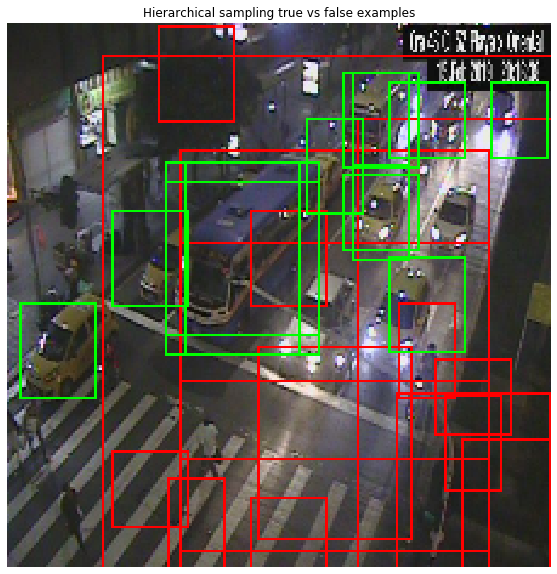

In [34]:
tensor = next(iter(ds))
anchors = tensor[1].numpy()
img = tensor[0].numpy()[:, :]

neg = anchors[anchors[:, 0] == -1]
pos = anchors[anchors[:, 0] != -1]

img = plot_bb(img, neg, (255, 0, 0), 1)
img = plot_bb(img, pos, (0, 255, 0), 1)

plt.figure(figsize = (10,10))
plt.imshow(img)
plt.axis('off')
plt.title('Hierarchical sampling true vs false examples');

In [35]:
tensor = next(iter(ds))

In [36]:
_, anchor_bbox, ground_truth = tensor

In [37]:
anchors = tf.cast(tf.constant(gen_anch(base_size=4,
                                       ratios=[1, 1.25, 1.5, 1.75, 2],
                                       scales=2 ** np.arange(3, 10))), tf.int32)
W = 12
H = 12
k = len(anchors)

dx = int(np.ceil(224 / W)) * tf.range(W, dtype=tf.int32)
dy = int(np.ceil(224 / H)) * tf.range(H, dtype=tf.int32)

dy = tf.reshape(dy, (-1, 1, 1))
dx = tf.reshape(dx, (1, -1, 1))

dx = tf.concat([dx, tf.zeros((1, W, 1), dtype=tf.int32)], axis=-1)
dy = tf.concat([tf.zeros((H, 1, 1), dtype=tf.int32), dy], axis=-1)

reference = tf.reshape(dx + dy, (1, H, W, 1, 2))
reference = tf.concat([reference, reference], axis=-1)

anchors = reference + tf.reshape(anchors, (1, 1, 1, k, 4))
anchors = tf.transpose(anchors, [0, 2, 1, 3, 4])

In [38]:
print(anchors[0, 0, 0, 0])
print(anchors[0, 10, 0, 0])
print(anchors[0, 0, 10, 0])

tf.Tensor([-14 -14  17  17], shape=(4,), dtype=int32)
tf.Tensor([176 -14 207  17], shape=(4,), dtype=int32)
tf.Tensor([-14 176  17 207], shape=(4,), dtype=int32)


In [39]:
cond = tf.equal(tf.reshape(anchor_bbox[:, 1:], (-1, 1, 1, 1, 4)), anchors)
cond = tf.reduce_all(cond, axis=-1)
anchor_map = tf.cast(tf.where(cond), tf.int32)

#anchor_map # De aqui sacaré los k

In [40]:
anchor_map

<tf.Tensor: id=6142, shape=(32, 4), dtype=int32, numpy=
array([[ 0,  5,  5,  8],
       [ 1,  7,  8,  2],
       [ 2, 10,  4,  0],
       [ 3,  1,  7,  7],
       [ 4,  8,  2,  7],
       [ 5,  8,  4, 14],
       [ 6,  6,  6, 30],
       [ 7,  8,  4, 21],
       [ 8,  7,  3, 29],
       [ 9,  8,  2,  0],
       [10,  2,  3,  8],
       [11,  3, 10, 28],
       [12,  6, 10, 30],
       [13,  5, 10, 23],
       [14,  6,  1, 14],
       [15,  8,  2, 21],
       [16,  5,  5,  1],
       [17,  9,  3, 14],
       [18,  5,  5, 22],
       [19,  4,  5, 15],
       [20,  3,  7, 15],
       [21, 11,  7,  9],
       [22,  1,  6, 14],
       [23,  7,  5, 22],
       [24,  8,  4, 14],
       [25,  8,  9, 14],
       [26, 11,  2, 14],
       [27,  8,  6,  7],
       [28,  8,  2,  7],
       [29,  7,  8, 17],
       [30,  5,  5,  8],
       [31,  9,  3, 28]], dtype=int32)>

In [41]:
gt_pointer = anchor_bbox[:, :1]
p_raw = tf.cast(gt_pointer != -1, tf.int32)

In [42]:
p_loc_raw = tf.cast(anchor_map[:, -1:] * 2, tf.int32) + p_raw
p_loc = tf.concat([anchor_map[:, 1:-1], p_loc_raw], axis=-1)
p_loc

<tf.Tensor: id=6162, shape=(32, 3), dtype=int32, numpy=
array([[ 5,  5, 17],
       [ 7,  8,  4],
       [10,  4,  1],
       [ 1,  7, 15],
       [ 8,  2, 15],
       [ 8,  4, 29],
       [ 6,  6, 60],
       [ 8,  4, 43],
       [ 7,  3, 58],
       [ 8,  2,  1],
       [ 2,  3, 16],
       [ 3, 10, 56],
       [ 6, 10, 60],
       [ 5, 10, 46],
       [ 6,  1, 28],
       [ 8,  2, 43],
       [ 5,  5,  3],
       [ 9,  3, 29],
       [ 5,  5, 45],
       [ 4,  5, 30],
       [ 3,  7, 30],
       [11,  7, 18],
       [ 1,  6, 28],
       [ 7,  5, 44],
       [ 8,  4, 29],
       [ 8,  9, 28],
       [11,  2, 29],
       [ 8,  6, 15],
       [ 8,  2, 15],
       [ 7,  8, 34],
       [ 5,  5, 17],
       [ 9,  3, 56]], dtype=int32)>

In [43]:
p_template = np.zeros((12, 12, 70))
p = tf.tensor_scatter_nd_update(p_template, p_loc, tf.ones(32)) ####### HERE

In [44]:
gt_mask = tf.cast(p_raw[:,0], tf.bool)#, gt_pointer)
pointers = tf.gather(gt_pointer, tf.where(gt_mask)[:, 0])[:, 0]
tf.gather(ground_truth, pointers)[:, 1:]

<tf.Tensor: id=6189, shape=(16, 4), dtype=int32, numpy=
array([[ 72,  55, 131, 131],
       [177,  65, 193,  98],
       [  8, 111,  47, 156],
       [139,  18, 168,  59],
       [141,  64, 165,  94],
       [141,  64, 165,  94],
       [139,  18, 168,  59],
       [139,  18, 168,  59],
       [ 72,  55, 131, 131],
       [161,  45, 177,  70],
       [ 72,  55, 131, 131],
       [141,  64, 165,  94],
       [196,  28, 211,  46],
       [150,  98, 176, 143],
       [139,  18, 168,  59],
       [ 72,  55, 131, 131]], dtype=int32)>

In [45]:
ext_ground_truth = tf.concat([ground_truth, [[-1, 1, 2, 3, 4]]], axis=0)

In [46]:
_gt = tf.gather(ext_ground_truth,
                tf.where(tf.equal(-1, gt_pointer),
                         len(ground_truth) * tf.ones_like(gt_pointer),
                         gt_pointer ))[:, 0, 1:]

_gt = change_box_order(tf.cast(_gt, tf.float64))
_bb = change_box_order(tf.cast(anchor_bbox[:, 1:], tf.float64))

In [47]:
t_x = (_gt[:, 0] - _bb[:, 0]) / _bb[:, 2]
t_x = tf.reshape(t_x, (-1, 1))
t_y = (_gt[:, 1] - _bb[:, 1]) / _bb[:, 3]
t_y = tf.reshape(t_y, (-1, 1))
t_w = tf.math.log(_gt[:, 2] / _bb[:, 2])
t_w = tf.reshape(t_w, (-1, 1))
t_h = tf.math.log(_gt[:, 3] / _bb[:, 3])
t_h = tf.reshape(t_h, (-1, 1))
t_bbox = tf.concat([t_x, t_y, t_w, t_h], axis=-1)

In [48]:
t_loc_raw = tf.cast(anchor_map[:, -1:], tf.int32)
t_loc = tf.concat([anchor_map[:, 1:-1], t_loc_raw], axis=-1)

In [49]:
t_loc

<tf.Tensor: id=6308, shape=(32, 3), dtype=int32, numpy=
array([[ 5,  5,  8],
       [ 7,  8,  2],
       [10,  4,  0],
       [ 1,  7,  7],
       [ 8,  2,  7],
       [ 8,  4, 14],
       [ 6,  6, 30],
       [ 8,  4, 21],
       [ 7,  3, 29],
       [ 8,  2,  0],
       [ 2,  3,  8],
       [ 3, 10, 28],
       [ 6, 10, 30],
       [ 5, 10, 23],
       [ 6,  1, 14],
       [ 8,  2, 21],
       [ 5,  5,  1],
       [ 9,  3, 14],
       [ 5,  5, 22],
       [ 4,  5, 15],
       [ 3,  7, 15],
       [11,  7,  9],
       [ 1,  6, 14],
       [ 7,  5, 22],
       [ 8,  4, 14],
       [ 8,  9, 14],
       [11,  2, 14],
       [ 8,  6,  7],
       [ 8,  2,  7],
       [ 7,  8, 17],
       [ 5,  5,  8],
       [ 9,  3, 28]], dtype=int32)>

In [50]:
t_template = np.zeros((12, 12, k, 4))
t = tf.tensor_scatter_nd_update(t_template, t_loc, t_bbox) ###### HERE

In [56]:
t.shape

TensorShape([12, 12, 35, 4])

In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications.vgg16 import VGG16

In [7]:
def RPN(inputs, k):
    x = Conv2D(256, kernel_size=(3, 3), 
               activation='relu',
               name='window')(inputs)
    cls = Conv2D(2 * k, kernel_size=(1, 1), name='cls_head')(x)
    reg = Conv2D(4 * k, kernel_size=(1, 1), name='reg_head')(x)
    return [cls, reg]

In [8]:
k = 35
inputs = Input(shape=(224, 224, 3))
backbone_model = VGG16(input_tensor=inputs,
                       weights='imagenet',
                       include_top=False)
x = backbone_model.layers[-5].output
model = Model(inputs=inputs, outputs=RPN(x, k))

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
______________________________________________________________________________________________

In [10]:
def L_cls(p_true, p_pred):
    return tf.math.reduce_sum(tf.keras.losses.binary_crossentropy(p_true, p_pred))

def L_reg(t_true, t_pred):
    return tf.math.reduce_sum(tf.keras.losses.Huber()(t_true, t_pred))

In [11]:
adam = tf.optimizers.Adam(learning_rate=3e-4)
model.compile(optimizer=adam, loss=[L_cls, L_reg]) # ?? 

In [12]:
def RPN_data(anchors, img, anchor_bbox, ground_truth):
    k = anchors.shape[3]
    
    cond = tf.equal(tf.reshape(anchor_bbox[:, 1:], (-1, 1, 1, 1, 4)), anchors)
    cond = tf.reduce_all(cond, axis=-1)
    anchor_map = tf.cast(tf.where(cond), tf.int32)
    
    gt_pointer = anchor_bbox[:, :1]
    p_raw = tf.cast(gt_pointer != -1, tf.int32)
    
    p_loc_raw = tf.cast(anchor_map[:, -1:] * 2, tf.int32) + p_raw
    p_loc = tf.concat([anchor_map[:, 1:-1], p_loc_raw], axis=-1)
    p_template = tf.zeros((12, 12, 70), dtype=tf.float64)
    
    p = tf.tensor_scatter_nd_update(p_template, p_loc, tf.ones(32, dtype=tf.float64))
    
    gt_mask = tf.cast(p_raw[:,0], tf.bool)#, gt_pointer)
    pointers = tf.gather(gt_pointer, tf.where(gt_mask)[:, 0])[:, 0]
    tf.gather(ground_truth, pointers)[:, 1:]
    
    ext_ground_truth = tf.concat([ground_truth, [[-1, 1, 2, 3, 4]]], axis=0)
    
    _gt = tf.gather(ext_ground_truth,
                tf.where(tf.equal(-1, gt_pointer),
                         len(ground_truth) * tf.ones_like(gt_pointer),
                         gt_pointer ))[:, 0, 1:]

    _gt = change_box_order(tf.cast(_gt, tf.float64))
    _bb = change_box_order(tf.cast(anchor_bbox[:, 1:], tf.float64))
    
    t_x = (_gt[:, 0] - _bb[:, 0]) / _bb[:, 2]
    t_x = tf.reshape(t_x, (-1, 1))
    t_y = (_gt[:, 1] - _bb[:, 1]) / _bb[:, 3]
    t_y = tf.reshape(t_y, (-1, 1))
    t_w = tf.math.log(_gt[:, 2] / _bb[:, 2])
    t_w = tf.reshape(t_w, (-1, 1))
    t_h = tf.math.log(_gt[:, 3] / _bb[:, 3])
    t_h = tf.reshape(t_h, (-1, 1))
    t_bbox = tf.concat([t_x, t_y, t_w, t_h], axis=-1)
    
    t_loc_raw = tf.cast(anchor_map[:, -1:], tf.int32)
    t_loc = tf.concat([anchor_map[:, 1:-1], t_loc_raw], axis=-1)
    
    t_template = tf.zeros((12, 12, k, 4), dtype=tf.float64)
    t = tf.tensor_scatter_nd_update(tensor=tf.cast(t_template, tf.float64), 
                                    indices=tf.cast(t_loc, tf.int32),
                                    updates=tf.cast(t_bbox, tf.float64))
    t = tf.reshape(t, (12, 12, -1))
    return img, (p, t)

In [13]:
def precompute_ancors_position():
    anchors = tf.cast(tf.constant(gen_anch(base_size=4,
                                       ratios=[1, 1.25, 1.5, 1.75, 2],
                                       scales=2 ** np.arange(3, 10))), tf.int32)
    k = len(anchors)
    W = 12
    H = 12
    print(k)

    dx = int(np.ceil(224 / W)) * tf.range(W, dtype=tf.int32)
    dy = int(np.ceil(224 / H)) * tf.range(H, dtype=tf.int32)

    dy = tf.reshape(dy, (-1, 1, 1))
    dx = tf.reshape(dx, (1, -1, 1))

    dx = tf.concat([dx, tf.zeros((1, W, 1), dtype=tf.int32)], axis=-1)
    dy = tf.concat([tf.zeros((H, 1, 1), dtype=tf.int32), dy], axis=-1)

    reference = tf.reshape(dx + dy, (1, H, W, 1, 2))
    reference = tf.concat([reference, reference], axis=-1)

    anchors = reference + tf.reshape(anchors, (1, 1, 1, k, 4))
    anchors = tf.transpose(anchors, [0, 2, 1, 3, 4])
    return anchors

In [14]:
anchors = precompute_ancors_position()
ds = ds.map(lambda img, anchor_bbox, ground_truth: 
            RPN_data(anchors, img, anchor_bbox, ground_truth))

35


In [15]:
model.fit_generator(ds.batch(1))

 18/521 [>.............................] - ETA: 20:40 - loss: 204.6174 - cls_head_loss: 201.2694 - reg_head_loss: 3.3479

KeyboardInterrupt: 